<a href="https://colab.research.google.com/github/angkoryy/models/blob/master/Traffic_Flow_Forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time series forecasting-Traffic Flow Forcasting**
**Authors:** Wu Yangyang

**Data created:** 2021/04/07

**Data_set:** Metro_Interstate_Traffic_Volume_Data_Set

Hourly Minneapolis-St Paul, MN traffic volume for westbound I-94. Includes weather and holiday features from 2012-2018.


# **Setup**

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.4.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: termcolor, grpcio, flatbuffers, absl-py, google-pasta, numpy, opt-einsum, wheel, six, h5py, wrapt, tensorflow-estimator, typing-extensions, astunparse, tensorboard, keras-preprocessing, gast, protobuf
Required-by: fancyimpute


In [ ]:
!/opt/bin/nvidia-smi

Thu Apr 15 10:14:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import os

tensorflow_version = tf.__version__
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# **Traffic volume Time_Series**
We will be using Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301 dataset.The dataset consists of 6 features such as holiday, temperature, snow_1h etc, recorded once per hour.

**location:**  Roughly midway between Minneapolis and St Paul, MN.

**Time-frame Considered:** Oct. 02, 2012 - Sep. 30, 2018

The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |date_time      |2012/10/2  9:00:00|Date-time reference
2    |holiday       |none             |holiday Categorical, US National holidays plus regional holiday, Minnesota State Fair 
3    |temp       |288.28              |Numeric Average temperature in Kelvin
4    |rain_1h       |0              |Numeric Amount in mm of rain that occurred in the hour
5    |snow_1h    |0               |Numeric Amount in mm of snow that occurred in the hour
6    |clouds_all (%)         |40               |Numeric Percentage of cloud cover
7    |traffic_volume   |5545               |Numeric Hourly I-94 ATR 301 reported westbound traffic volume


In [ ]:
csv_path = "Re_Metro_Interstate_Traffic_Volume.csv"

df = pd.read_csv(csv_path)
print(df.head(3))

         date_time    temp  rain_1h  snow_1h  clouds_all  traffic_volume
0   2012/10/2 9:00  288.28      0.0      0.0          40            5545
1  2012/10/2 10:00  289.36      0.0      0.0          75            4516
2  2012/10/2 11:00  289.58      0.0      0.0          90            4767


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Raw Data Visualization**
Each feature has been plotted below. This shows the distinct pattern of each feature over the time period from 2012 to 2018.

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,48204.0,281.258894,12.713645,243.39,272.16,282.45,291.806,310.07
rain_1h,48204.0,0.130312,1.003368,0.00,0.00,0.00,0.000,55.63
snow_1h,48204.0,0.000222,0.008168,0.00,0.00,0.00,0.000,0.51
clouds_all,48204.0,49.362231,39.015750,0.00,1.00,64.00,90.000,100.00
traffic_volume,48204.0,3259.818355,1986.860670,0.00,1193.00,3380.00,4933.000,7280.00


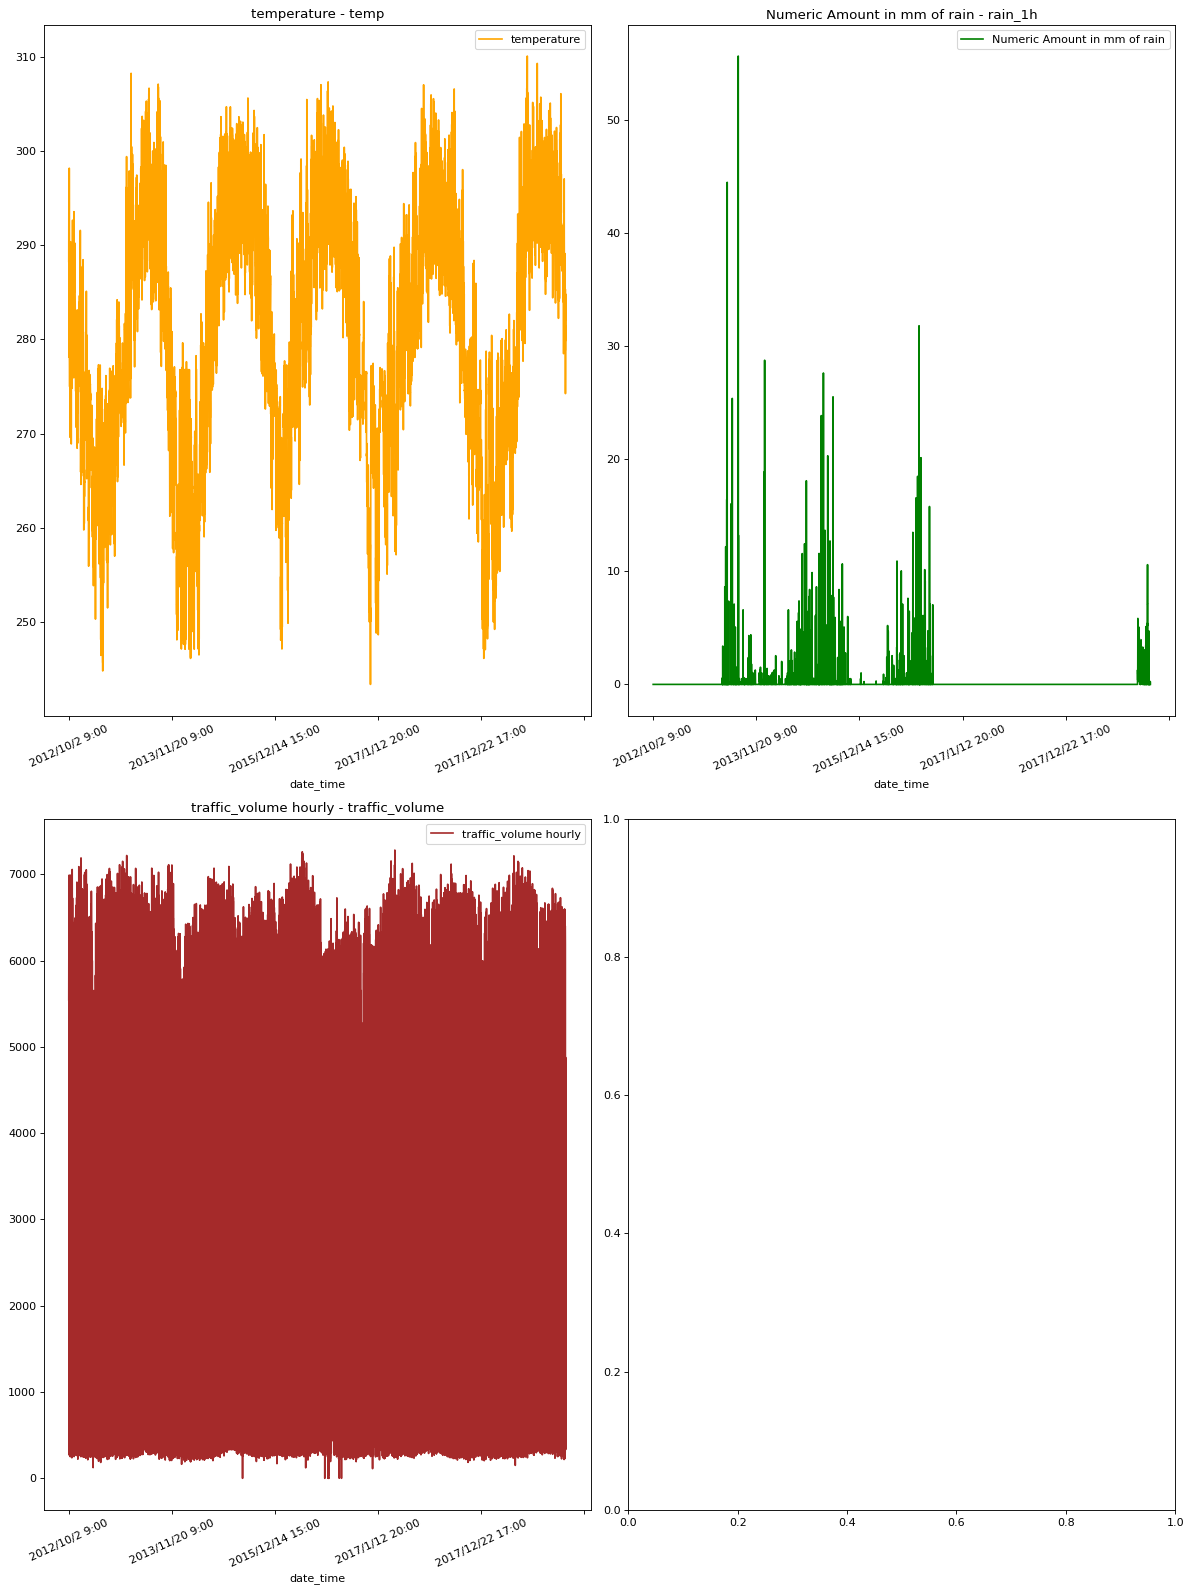

In [ ]:

titles = [
#    "holiday",
    "temperature",
    "Numeric Amount in mm of rain",
#    "Numeric Amount in mm of snow",
#    "Numeric Percentage of cloud cover",
    "traffic_volume hourly",

]

feature_keys = [
#        "holiday",
    "temp", #11900-11903,11948-11953行共缺失10个数据，温度为0值
    "rain_1h", #24874行有异常值9831.3
#    "snow_1h",
#    "clouds_all",
    "traffic_volume",

]

colors = [
    "orange",
    "green",
#    "red",
#    "purple",
    "brown",
#    "pink",

]

date_time_key = "date_time"

def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()

show_raw_visualization(df)

Use the heat map to show the correlation between different features.

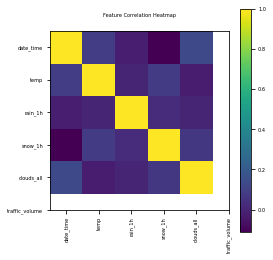

In [ ]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=5, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=5)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=5)
    plt.title("Feature Correlation Heatmap", fontsize=5)
    plt.show()

show_heatmap(df)


# **Data Preprocessing**

There are 48204 data points totally. Here we are picking 36,054 data points for training, and 12,018 data points for validation.

We are tracking data from past 120 timestamps. This data will be used to predict the volume after 12 timestamps.

Since every feature has values with varying ranges, we do normalization to confine feature values to a range of [0, 1] before training a neural network. We do this by subtracting the mean and dividing by the standard deviation of each feature.

75 % of the data will be used to train the model, i.e. 36,054 rows. `split_fraction` can be changed to alter this percentage.

The model is shown data for first 5 days i.e. 120 observations, that are sampled every hour. The volume after 12 observation will be used as a label.

In [ ]:
split_fraction = 0.75
train_split = int(split_fraction * int(df.shape[0]))
step = 1

past = 120
future = 12
learning_rate = 0.005
batch_size = 128 #要设置为2的倍数，方便GPU分配内存
epochs = 50


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std #得到均值和标准差后，通过此公式将数据值限幅在[0,1]


In [ ]:
features = df[feature_keys] #选择输入特征数据
features.index = df[date_time_key] #获得选择后的输入特征的索引号
features.head() #df.head：查看DataFrame中头部和尾部的行

features = normalize(features.values, train_split) #调用上面定义的数据标准化函数，这里features.values(输入特征对象的值)对应的形参为data.
features = pd.DataFrame(features) #通过pandas创建名为features的DataFrame对象，由行和列组成
features.head()

train_data = features.loc[0 : train_split - 1] #从所有标准化后的features中划分出训练集(包含数据和标签)；  df.loc：通过标签进行选择
val_data = features.loc[train_split:] #从所有标准化后的features中划分出验证集（包含数据和标签）

print(train_data.shape)
print(val_data.shape)

(36153, 3)
(12051, 3)


# **Training dataset**
The training dataset labels starts from the 132nd observation (120 + 12).

In [ ]:
start = past + future # 132 = 120 + 12
end = start + train_split #end=132+...

x_train = train_data[[i for i in range(3)]].values #从上面定义出的train_data取其values作为 训练集数据
y_train = features.iloc[start:end][[2]] # 训练集标签：features的第5列；  df.iloc：通过位置进行选择
#y_train = features.iloc[[j for j in range(7)][1]] #这一行错误！
sequence_length = int(past / step) #因为本模型已说明 resample为每小时一次，所以序列长度为120/1

print("x_train[0]:\n", x_train[0])
print("x_train.shape:\n", x_train.shape)
print("y_train.shape:\n", y_train.shape)

x_train[0]:
 [ 0.58068838 -0.13122836  1.15554208]
x_train.shape:
 (36153, 3)
y_train.shape:
 (36153, 1)


The `timeseries_dataset_from_array` function takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as length of the
sequences/windows, spacing between two sequence/windows, etc., to produce batches of
sub-timeseries inputs and targets sampled from the main timeseries.

In [ ]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length, #sequence_length=120
    sampling_rate=step, #采样频率为每小时一次（因此共采样120次）
    batch_size=batch_size,
    #shuffle=false, #这里没写出，默认是false,没有随机打散
)

# **Validation dataset**
The validation dataset must not contain the last 132 rows as we won't have label data for those records, hence 132 must be subtracted from the end of the data.

The validation label dataset must start from 132 after train_split, hence we must add past + future (132) to label_start.

In [ ]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(3)]].values #通过数值进行选择

y_val = features.iloc[label_start:][[2]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (128, 120, 3)
Target shape: (128, 1)


# **Training**

In [ ]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
#dense1 = keras.layers.Dense(32,activation='relu'
#    units=5, activation=keras.activations.relu(5), use_bias=True,
#    kernel_initializer='glorot_uniform', bias_initializer='zeros',
#    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
#    kernel_constraint=None, bias_constraint=None)
lstm_1 = keras.layers.LSTM(32,return_sequences=True)(inputs)
lstm_2 = keras.layers.LSTM(32,dropout=0.2)(lstm_1)
#lstm_3 = keras.layers.GRU(32)(lstm_2)
outputs = keras.layers.Dense(1)(lstm_2)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate), 
    loss="mse")
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 3)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 120, 32)           4608      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 12,961
Trainable params: 12,961
Non-trainable params: 0
_________________________________________________________________


We'll use the `ModelCheckpoint` callback to regualrly save checkpoints, and
the `EarlyStopping` callback to interrupt training when the validation loss
is not longer improving.

In [ ]:
path_checkpoint = "model_checkpoint.h5"

#path_checkpoint = "./checkpoint.ckpt"
#if os.path.exists(path_checkpoint + '.index'):
#    print('-------------load the model-----------------')
#    model.load_weights(path_checkpoint)

earlystopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=10,verbose=0)

modelcheckpoint = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=0,
    save_weights_only=True,
    save_best_only=True,
)
#csvlogger = keras.callbacks.CSVLogger(filename='run/log.csv',
#    separator=',', append=False)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[earlystopping, modelcheckpoint],
)


Epoch 1/50
282/282 [==============================] - 12s 34ms/step - loss: 0.8702 - val_loss: 0.7136
Epoch 2/50
282/282 [==============================] - 9s 32ms/step - loss: 0.7492 - val_loss: 0.5985
Epoch 3/50
282/282 [==============================] - 9s 33ms/step - loss: 0.6895 - val_loss: 0.5531
Epoch 4/50
282/282 [==============================] - 9s 33ms/step - loss: 0.6607 - val_loss: 0.5436
Epoch 5/50
282/282 [==============================] - 9s 33ms/step - loss: 0.6430 - val_loss: 0.5484
Epoch 6/50
282/282 [==============================] - 9s 33ms/step - loss: 0.6284 - val_loss: 0.5269
Epoch 7/50
282/282 [==============================] - 9s 33ms/step - loss: 0.6087 - val_loss: 0.5318
Epoch 8/50
282/282 [==============================] - 9s 33ms/step - loss: 0.5986 - val_loss: 0.5502
Epoch 9/50
282/282 [==============================] - 9s 33ms/step - loss: 0.5920 - val_loss: 0.5355
Epoch 10/50
282/282 [==============================] - 9s 33ms/step - loss: 0.5793 - val_l

Visualize the loss with the function below. 

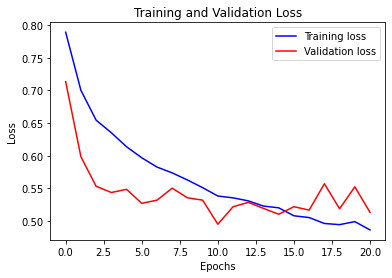

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

# **Prediction**
The trained model above is now able to make predictions for 5 sets of values from validation set.

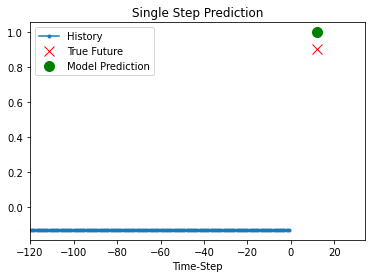

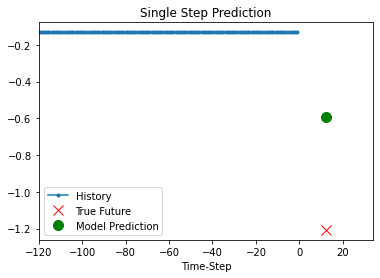

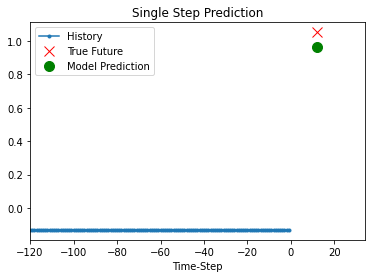

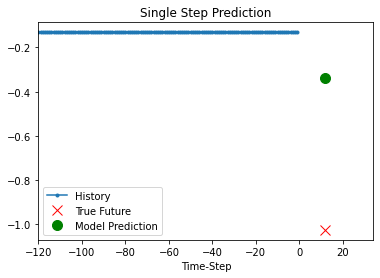

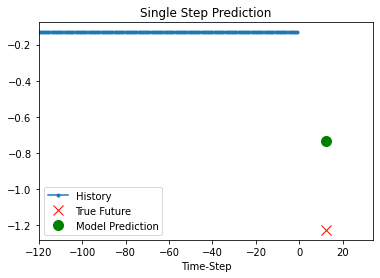

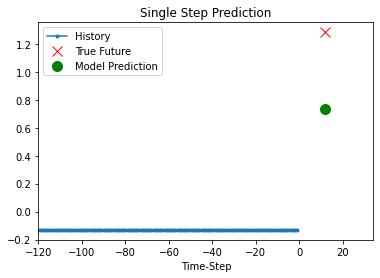

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(6):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )